#  January 2014 Cesar Data




To do the sunrise/sunset calculations you'll need to do:

```
conda install dateutil
conda install ephem
```

On windows, you can get an ncdump executable [here](http://www.unidata.ucar.edu/software/netcdf/docs/winbin.html)

In [824]:
!pwd

/home/wesley/atsc500/notebooks


In [825]:
import glob
from netCDF4 import Dataset
from dateutil.parser import parse
import datetime
import numpy as np
import matplotlib.dates as mdates


The make_date function takes an open CESAR ncfile and turns the time
vector from hours past the start date into a python datetime object
in UTC.  It uses the dateutil parse function to turn the date_start_of_data
string into a date.

In [826]:
def make_date(ncfile):
    """
    ncfile:  open netCDF4 Dataset
    returns:
       numpy array of datetime objects
    """
    the_time=f.variables['time'][...]
    start_date=f.variables['product'].date_start_of_data
    start_date = parse(start_date)
    time_vec=[]
    for the_hour in the_time:
        time_vec.append(start_date + datetime.timedelta(hours=float(the_hour)))
    time_vec=np.array(time_vec)
    return time_vec


Loop through all the files and make a dictionary with keys determined
by the netcdf file attributes.  Initially the dictionary contains the
filename, start_date, lat, lon and start time.

In [827]:
all_files=glob.glob('cesar*.nc')
data_dict={}
for the_file in all_files:
    with Dataset(the_file,'r') as f:
        details=f.variables['iso_dataset']
        attributes=details.ncattrs()
        attr_dict={}
        for attr in attributes:
            attr_dict[attr]=getattr(details,attr)
        lon=attr_dict['westbound_longitude']
        lat=attr_dict['northbound_latitude']
        title=attr_dict['title'].split()
        the_time = make_date(f)
        #
        # turn a title like:
        #"CESAR surface fluxes validated and gap filled"
        # into the string: surface_fluxes
        #
        filetype='{}_{}'.format(*title[1:3])
        start_date=f.variables['product'].date_start_of_data
        start_date=parse(start_date)
        start_month=start_date.strftime('%Y%m')
    data_dict[filetype,start_month]=dict(name=the_file,start=start_date,lat=lat,lon=lon,
                                         time=the_time)

Now loop through the dictionary and add the flux and tower variables.
Each variable is a linear vector of measurements taken every 10 minutes, and
for tower variables, at 7 levels.

The numpy command:
var.reshape(-1,24,6,7)
takes the linear vector and folds it into either 28,29,30,31 days (depending on monty)
24 hours, 6 10 minute intervals, and 7 levels

That allows us to do an hourly average by saying:
var.mean(axis=2)  to average over the 6 10 minute measurements.

In [828]:
for the_key in data_dict.keys():
    if the_key[0] == 'tower_meteorological':
        var_dict=data_dict[the_key]
        with Dataset(var_dict['name'],'r') as f:
            var_dict['z'] = f.variables['z'][...]
            for var in ['F','TA','TD','Q']:
                var_dict[var] = f.variables[var][...].reshape(-1,24,6,7)
    elif the_key[0] == 'surface_fluxes': 
        var_dict=data_dict[the_key]
        with Dataset(var_dict['name'],'r') as f:
            for var in ['H','UST','LE']:
                var_dict[var] = f.variables[var][...]
    elif the_key[0] == 'meteorological_surface': 
        var_dict=data_dict[the_key]
        with Dataset(var_dict['name'],'r') as f:
            for var in ['P0','TA002','Q002','F010']:
                var_dict[var] = f.variables[var][...]
    elif the_key[0] == 'scanning_radiometer':
        pass
    else:
        raise ValueError("didn't recognize {}".format(the_key[0]))

We'll need to know sunrise, sunset and solar noon to interpret our
data.  Here is how you find these with the 
[pyephem](http://stackoverflow.com/questions/2637293/calculating-dawn-and-sunset-times-using-pyephem) module

In [829]:
month='201401'
import ephem
var='tower_meteorological'
tower_dict=data_dict[var,month]

start_time=tower_dict['time'][0]
cabauw=ephem.Observer()
cabauw.date=start_time
cabauw.lon = tower_dict['lon']
cabauw.lat = tower_dict['lat']
sunrise=cabauw.next_rising(ephem.Sun())
noon = cabauw.next_transit(ephem.Sun(),start=sunrise)
sunset = cabauw.next_setting(ephem.Sun())
print('sunrise is {} UTC'.format(sunrise))
print('solar noon {} UTC'.format(noon))
print('sunset is {} UTC'.format(sunset))

sunrise is 2014/1/1 07:47:48 UTC
solar noon 2014/1/1 11:43:50 UTC
sunset is 2014/1/1 15:40:04 UTC


# Obukhov Lenght


In [830]:
var = 'meteorological_surface'
surf_dict = data_dict[var,month]

var = 'surface_fluxes'
flux_dict = data_dict[var,month]

var = 'meteorological_surface'
met_dict = data_dict[var,month]

Rd = 287
cp = 1004
g = 9.8
k = 0.4
Z = 2
P0 = surf_dict['P0'].reshape(-1,24,6)
Ust = flux_dict['UST'].reshape(-1,24,6)
Temp = met_dict['TA002'].reshape(-1,24,6) + 273.15
Le = flux_dict['LE'].reshape(-1,24,6)
H = flux_dict['H'].reshape(-1,24,6)
Q = met_dict['Q002'].reshape(-1,24,6)
Eb = H + 0.2*Le


Theta=Temp*(1000/P0)**(Rd/cp)
Theta_v = Theta*(1 + 0.61*Q/1000)
L = -Theta_v*Ust**3/(k*Z*Eb)

# Fleagle & Businger Profile Fits

In [831]:
z0 = 0.03    #### as per Cesar surface flux description
Z_tower = tower_dict['z']
alpha = 16
Beta = 4.7
Zeta = Z/L
Psim = np.zeros(shape = Zeta.shape)
Term2 = np.zeros(shape = Zeta.shape)                             # Phi for L<0 B*zeta for L>0
Psim[Zeta<0]=(1-alpha*Zeta[Zeta<0])**0.25
Term2[Zeta<0]=(2*(np.log(1+Psim[Zeta<0]**-1)/2) +np.log((1+Psim[Zeta<0]**-2)/2)) - 2*np.arctan(Psim[Zeta<0]**-1) + np.pi/2
Term2[Zeta>0]=Beta*Zeta[Zeta>0]
Ubar=np.zeros(shape=Zeta.shape)
Shape=Zeta[:,:,:,np.newaxis]*Z_tower.T
U_prof=np.zeros(shape=Shape.shape)
for z in range(0,len(Z_tower)):
    Ubar[Zeta>0]=Ust[Zeta>0]/k*(np.log(Z_tower[z]/z0)+Term2[Zeta>0])
    Ubar[Zeta<0]=Ust[Zeta<0]/k*(np.log(Z_tower[z]/z0)-Term2[Zeta<0])
    U_prof[:,:,:,z]= Ubar
U_prof=U_prof.mean(axis=2)

# Plots

[(-200, 200),

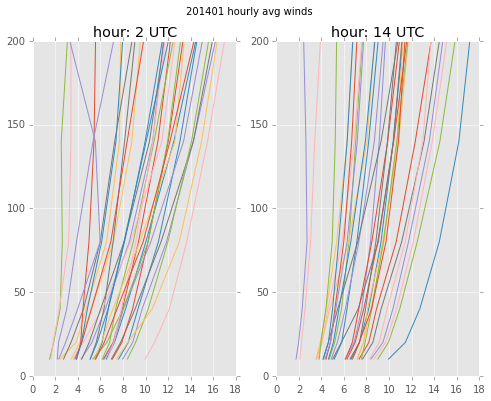

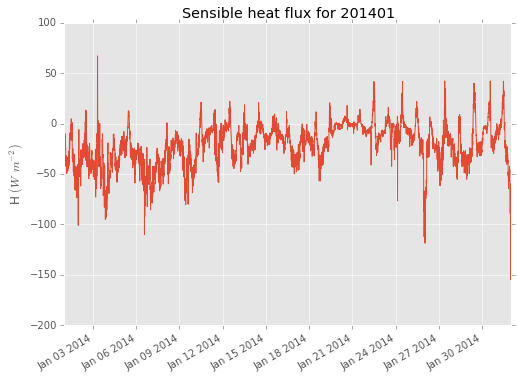

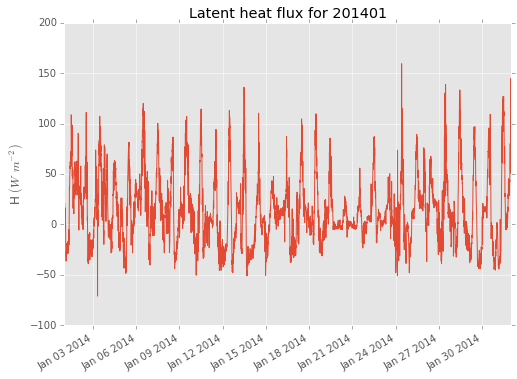

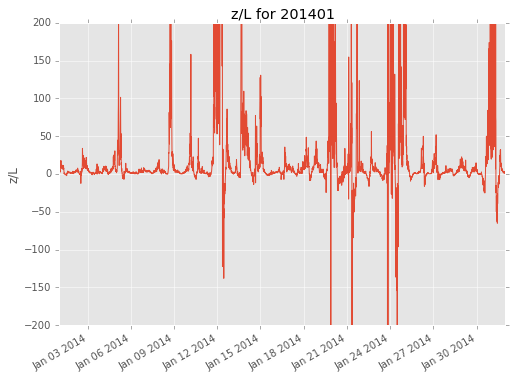

In [832]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.close('all')
    
var='tower_meteorological'
tower_dict=data_dict[var,month]
the_times=tower_dict['time'].reshape(-1,24,6)    

var='tower_meteorological'
tower_dict=data_dict[var,month]
hourly_wind_avg=tower_dict['F'].mean(axis=2)
z=tower_dict['z']

hour=2
fig,ax=plt.subplots(1,2,figsize=(8,6))
ax[0].plot(hourly_wind_avg[:,hour,:].T,z)
ax[0].set(title='hour: {} UTC'.format(hour))
hour=14
ax[1].plot(hourly_wind_avg[:,hour,:].T,z)
ax[1].set(title='hour: {} UTC'.format(hour))
fig.suptitle('{} hourly avg winds'.format(month))

#
# date plotting tips at http://matplotlib.org/users/recipes.html
#

fig,ax=plt.subplots(1,1,figsize=(8,6))
fig.autofmt_xdate()
ax.plot(flux_dict['time'],flux_dict['H'])
title='Sensible heat flux for {}'.format(month)
ax.set(title=title,ylabel='H $(W\,m^{-2})$')

fig,ax=plt.subplots(1,1,figsize=(8,6))
fig.autofmt_xdate()
ax.plot(flux_dict['time'],flux_dict['LE'])
title='Latent heat flux for {}'.format(month)
ax.set(title=title,ylabel='H $(W\,m^{-2})$')

Zeta = np.ndarray.flatten(Zeta)

fig,ax=plt.subplots(1,1,figsize=(8,6))
fig.autofmt_xdate()
ax.plot(flux_dict['time'],Zeta)
title='z/L for {}'.format(month)
ax.set(title=title,ylabel='z/L',ylim = (-200,200))



# Calculated vs observed profiles

[<matplotlib.text.Text at 0x7f46232a0470>, (0, 20)]

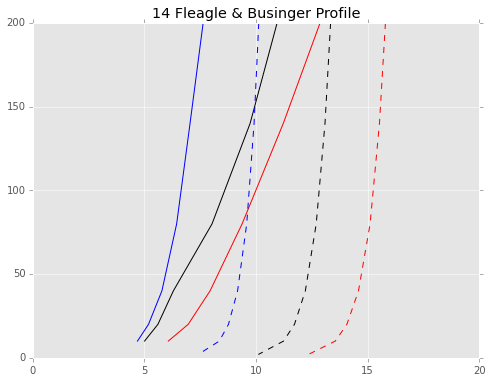

In [855]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
day=12
hour=0
ax.plot(U_prof[day,hour,:].T,z, color ='Black',linestyle = '--')
ax.plot(hourly_wind_avg[day,hour,:].T,z, color ='Black')
hour=9
ax.plot(U_prof[day,hour,:].T,z, color ='Red',linestyle = '--')
ax.plot(hourly_wind_avg[day,hour,:].T,z, color ='Red')
hour=14
ax.plot(U_prof[day,hour,:].T,z, color ='blue',linestyle = '--')
ax.plot(hourly_wind_avg[day,hour,:].T,z, color ='blue')
ax.set(title='{} Fleagle & Businger Profile'.format(hour), xlim=(0,20))

It appears that the profile gets the shape about right, but greatly over estimates the observations.